In [1]:
import os
from pathlib import Path
import numpy as np
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import torch
import sys
sys.path.append('../')

In [2]:
from models.models import *
from utils.datasets import create_dataloader
from utils.general import non_max_suppression, increment_path, check_dataset, check_img_size
from utils.torch_utils import select_device
from feature_mining.visualize_utils import *

In [3]:
# Set parameters
%matplotlib inline
imgsz=1600
imgsz_test=1600
# img_size = (1600, 900)
batch_size=1
gs=64
cache_image=True
rect=True
pad=0.5
conf_thres=0.001
iou_thres=0.6
cfg = '../cfg/yolov4-tiny-25.cfg'
device_str = 'gpu:1'
weights='../weights/best.pt'
data='../data/nuimages.yaml'
image_id=12
save_dir = Path(increment_path(Path('runs/visualize') / 'yolov4-tiny-25', exist_ok=True))  # increment run
save_dir.mkdir(parents=True, exist_ok=True)

In [4]:
print(torch.cuda.is_available())
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
assert torch.cuda.is_available(), 'CUDA unavailable, invalid device %s requested' % device

True
Python version
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
Version info.
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


### Load Model

In [5]:
from models import models

device = select_device(device_str)

# Load with checkpoint
model = Darknet(cfg).to(device)  # create model

ckpt = torch.load(weights, map_location=device)  # load checkpoint
ckpt['model'] = {k: v for k, v in ckpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
model.load_state_dict(ckpt['model'], strict=False)

# Evaluation mode
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): FeatureConcat_l()
    (4): Sequential(
      (Conv2d): Conv2d(32, 32, kernel_size=(3, 3), 

In [6]:
img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
_ = model(img) if device.type != 'cpu' else None  # run once

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Load Data

In [7]:
imgsz = check_img_size(imgsz, s=64)
imgsz_test = check_img_size(imgsz_test, s=64)

with open(data) as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)  # data dict

check_dataset(data_dict)  # check    
train_path = data_dict['train']
val_path = data_dict['val']
test_path = data_dict['test']
nc, names = (int(data_dict['nc']), data_dict['names'])  # number classes, names
assert len(names) == nc, '%g names found for nc=%g dataset in %s' % (len(names), nc, opt.data)  # check
print(names)

['animal', 'flat.driveable_surface', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.ego', 'vehicle.emergency.ambulance', 'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck']


In [ ]:
trainloader, trainset = create_dataloader(train_path, imgsz, batch_size, gs)
mlc = np.concatenate(trainset.labels, 0)[:, 0].max()  # max label class
nb = len(trainloader)  # number of batches
assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Possible class labels are 0-%g' % (mlc, nc, data, nc - 1)

In [10]:
valloader, valset = create_dataloader(val_path, imgsz_test, batch_size, gs, rect=True, pad=pad)  # testloader
nb = len(valloader)  # number of batches

Scanning images: 100%|██████████| 16445/16445 [01:45<00:00, 156.22it/s]
Scanning labels /root/data/nuimages/labels/samples/CAM_BACK.cache3 (14873 found, 0 missing, 1572 empty, 0 duplicate, for 16445 images): 16445it [00:01, 9149.41it/s] 


In [8]:
testloader, testset = create_dataloader(test_path, imgsz_test, batch_size, gs, rect=True, pad=pad)  # testloader
nb = len(testloader)  # number of batches

Scanning images: 100%|██████████| 9752/9752 [00:15<00:00, 633.05it/s]
Scanning labels /root/data/nuimages/labels/samples/CAM_BACK.cache3 (0 found, 0 missing, 9752 empty, 0 duplicate, for 9752 images): 9752it [00:00, 358366.28it/s]

### Predict Using Model

  0%|          | 11/16445 [00:00<24:23, 11.23it/s]

torch.Size([1, 3, 960, 1664])


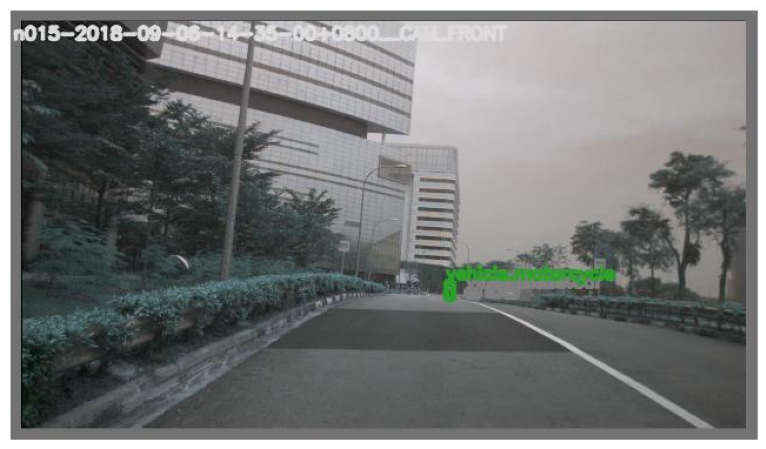

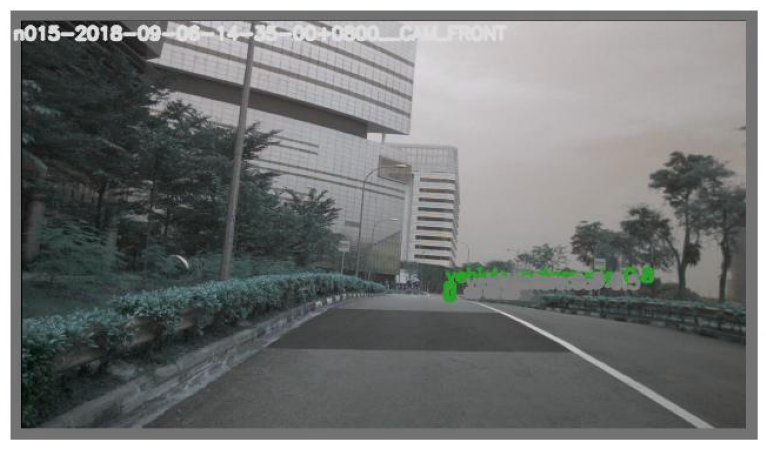

  0%|          | 12/16445 [00:01<40:30,  6.76it/s]


In [11]:
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(valloader)):
    if batch_i != image_id:
        continue
    img = img.to(device, non_blocking=True)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    print(img.shape)
    with torch.no_grad():
        pred = model(img)  # forward
    #     print(pred[0].shape)
    #     print(pred[1][0].shape)
    #     print(pred[1][1].shape)
    #     print(pred[0])
        output = non_max_suppression(pred[0], conf_thres=conf_thres, iou_thres=iou_thres)
    #     print(output)
        plot_boxes(save_dir,img,targets,paths,output,names)
    break
        

### Visualize

In [12]:
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

In [19]:
target_layers = model.module_list[35]
print(target_layers)

Sequential(
  (Conv2d): Conv2d(512, 90, kernel_size=(1, 1), stride=(1, 1))
)


In [20]:
cam = EigenCAM(model, target_layers, use_cuda=(device_str!='cpu'))

  0%|          | 12/16445 [00:01<30:56,  8.85it/s]

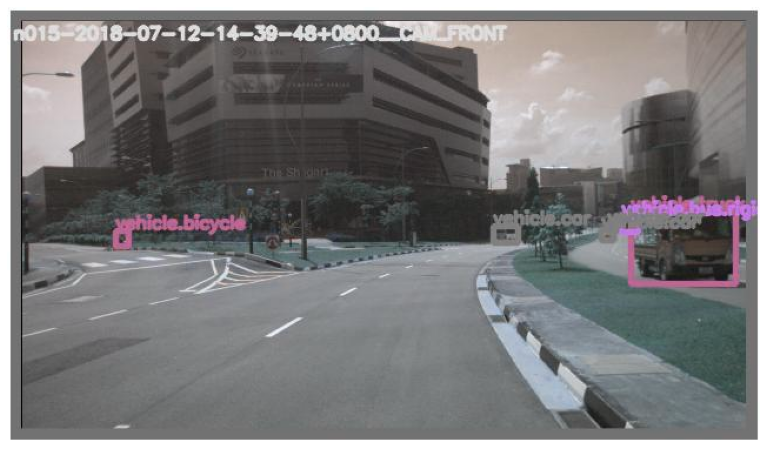

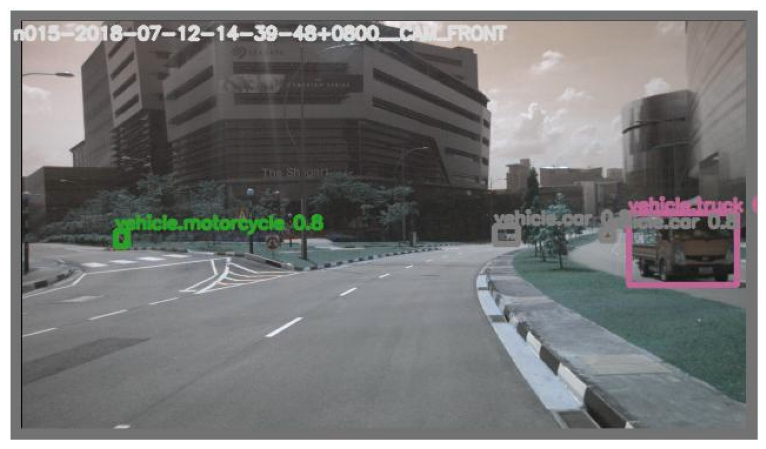

(960, 1664)
(3, 960, 1664)


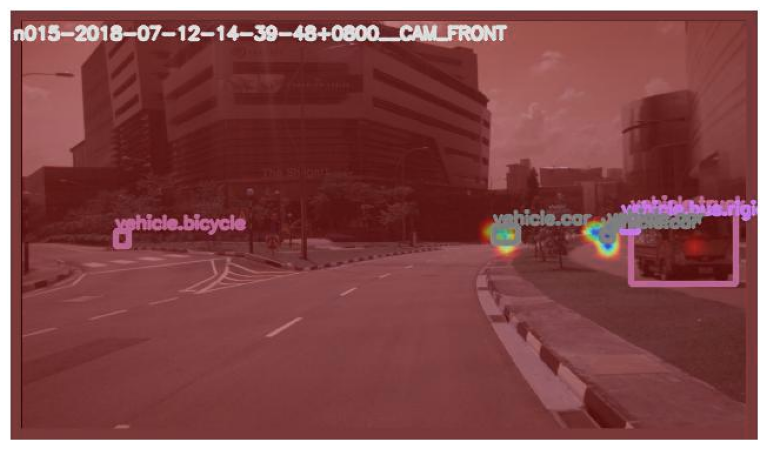

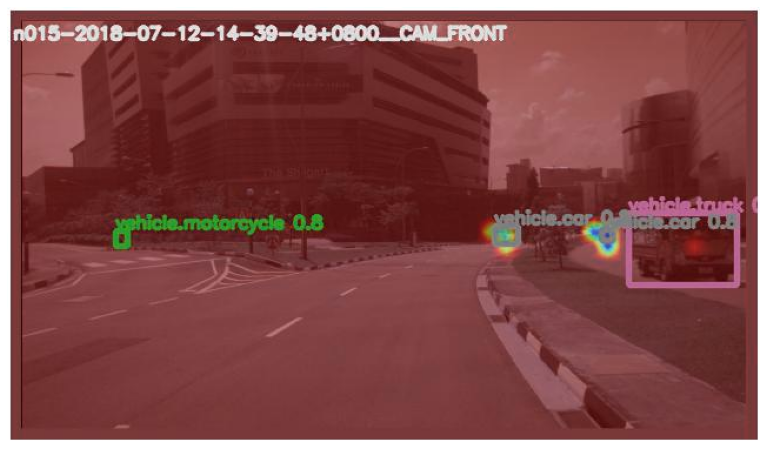

  0%|          | 12/16445 [00:02<1:03:30,  4.31it/s]


In [31]:
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(valloader)):
    if batch_i != image_id:
        continue
    img = img.to(device, non_blocking=True)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    img_cpy = torch.clone(img)
    
    with torch.no_grad():
        pred = model(img)  # forward
        output = non_max_suppression(pred[0], conf_thres=conf_thres, iou_thres=iou_thres)
        plot_boxes(save_dir, img, targets, paths, output, names)
        
    for si, pred_nms in enumerate(output): #enumerate to handle batches of predictions
        targets_cam = [Yolov4BoxScoreTarget(labels=pred_nms[:,5], bounding_boxes=pred_nms[:,:4],device=device,
                                            nms_conf_thres=conf_thres,nms_iou_thres=iou_thres)]
        grayscale_cam = cam(img_cpy, targets=targets_cam)[0, :, :]
        print(grayscale_cam.shape)
        img_cam = img_cpy[si].cpu().numpy()
        print(img_cam.shape)
        img_cam = img_cam.transpose(1,2,0)
        cam_image = show_cam_on_image(img_cam, grayscale_cam, use_rgb=True)
        cam_image = cam_image.transpose(2,0,1)
        cam_image = np.expand_dims(cam_image,axis=0)
        plot_boxes(save_dir, cam_image, targets, paths, output, names)
    break

In [22]:
cam = GradCAM(model, target_layers, use_cuda=(device_str!='cpu'))
#torch.autograd.set_detect_anomaly(True)

  0%|          | 12/16445 [00:01<26:58, 10.15it/s]

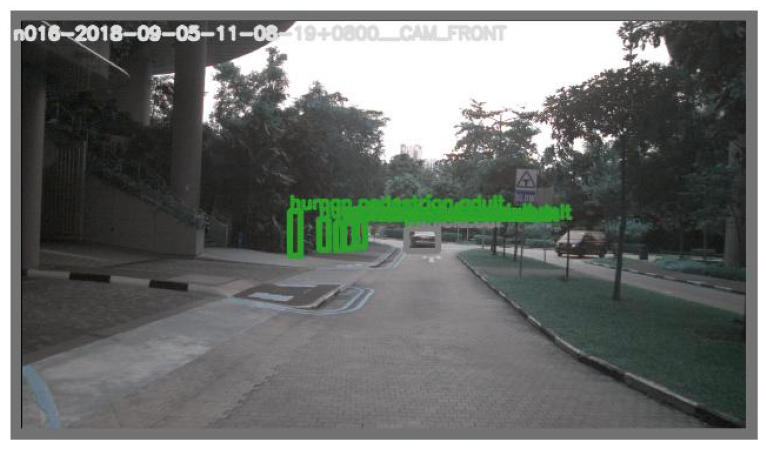

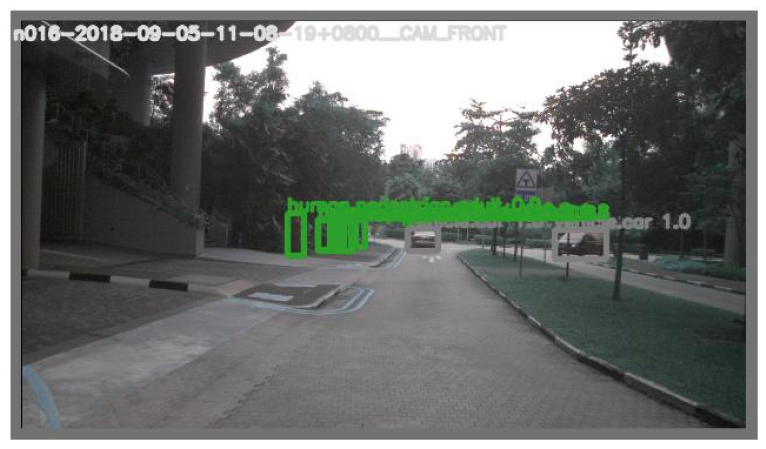

(960, 1664)
(3, 960, 1664)


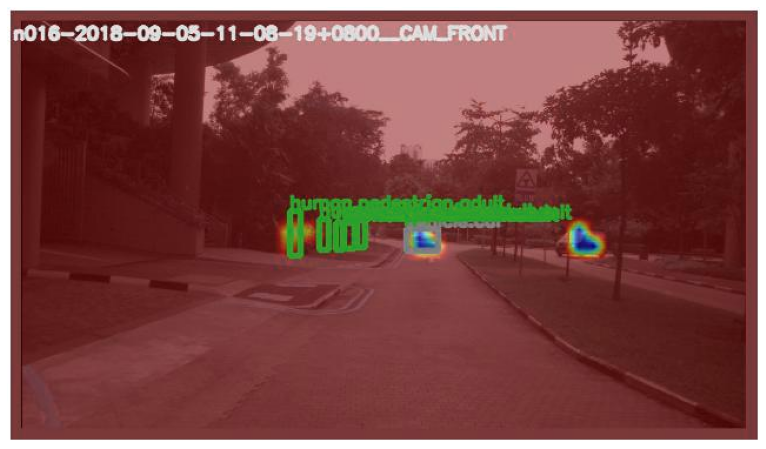

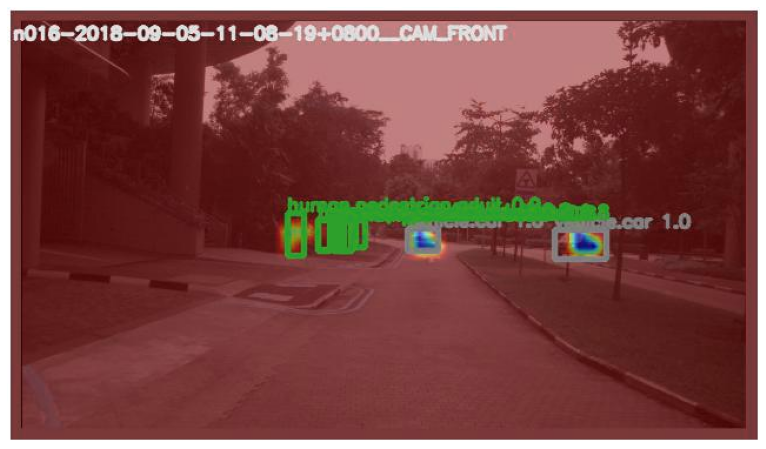

  0%|          | 12/16445 [00:02<1:06:11,  4.14it/s]


In [38]:
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(valloader)):
    if batch_i != image_id:
        continue
    img = img.to(device, non_blocking=True)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    img_cpy = torch.clone(img)
    
    with torch.no_grad():
        pred = model(img)  # forward
        output = non_max_suppression(pred[0], conf_thres=conf_thres, iou_thres=iou_thres)
        plot_boxes(save_dir, img, targets, paths, output, names)
        
    for si, pred_nms in enumerate(output): #enumerate to handle batches of predictions
        targets_cam = [Yolov4BoxScoreTarget(labels=pred_nms[:,5], bounding_boxes=pred_nms[:,:4],device=device,
                                           nms_conf_thres=conf_thres,nms_iou_thres=iou_thres)]
        grayscale_cam = cam(img_cpy, targets=targets_cam)[0, :, :]
        print(grayscale_cam.shape)
        img_cam = img_cpy[si].cpu().numpy()
        print(img_cam.shape)
        img_cam = img_cam.transpose(1,2,0)
        cam_image = show_cam_on_image(img_cam, grayscale_cam, use_rgb=True)
        cam_image = cam_image.transpose(2,0,1)
        cam_image = np.expand_dims(cam_image,axis=0)
        plot_boxes(save_dir, cam_image, targets, paths, output, names)
    break

In [9]:
from feature_mining.utils import *

In [10]:
cummAP = 0
cnt = 0
trgt_cnt = 0
zero_cnt = 0
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(valloader)):
    img = img.to(device, non_blocking=True)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    with torch.no_grad():
        pred = model(img)  # forward
        output = non_max_suppression(pred[0], conf_thres=conf_thres, iou_thres=iou_thres)
        assert len(output)==1, "batch size should be 1"
        img = torch.squeeze(img)
        output = output[0]
        labels = targets[targets[:, 0] == 0, 1:]
        labels = labels.to(device, non_blocking=True)
        mAP = mAP_per_image(img, output, labels, nc, device)
        if mAP == 0.0:
            zero_cnt += 1
#         print(mAP)
        cummAP += mAP
        cnt += 1
        trgt_cnt += labels.shape[0]
print(cummAP/cnt)

100%|██████████| 16445/16445 [08:05<00:00, 33.87it/s]

0.7587711788194295


In [11]:
print(cnt)
print(zero_cnt)
print(trgt_cnt)

16445
1708
135230
